#### Librerias

In [0]:
spark.conf.set("spark.databricks.io.cache.enabled", True)
spark.conf.set('spark.sql.shuffle.partitions', 'auto')

In [0]:
%run ../../../../../04_utils/commons_functions_de

### Librerías

### Funciones Ingenieria de datos

### Funciones de ingesta en RDS

### Funciones de control de flujo de ingesta

In [0]:
%run ../../../../../04_utils/commons_functions_ds

In [0]:
%run ../../../../../spigot/initial/global_parameter_py

In [0]:
spark.conf.set("spark.databricks.io.cache.enabled", True)
spark.conf.set('spark.sql.shuffle.partitions', 'auto')

from IPython.display import display
import mlflow
#mute warnings
import warnings
warnings.filterwarnings('ignore')

from pyspark.sql.types import IntegerType
import pyspark.sql.functions as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from pyspark.sql import Window
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import plotly.express as px

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)

sns.set_theme(style="ticks")

from datetime import datetime
from dateutil.relativedelta import relativedelta

pd.set_option('display.float_format', lambda x: '%.5f' % x)

from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA

from pyspark.sql.window import Window
from pyspark.sql.functions import row_number
import plotly.express as px
import plotly.graph_objects as go

try:    import mlflow
except ImportError:
    print('mlflow package is not installed or has issues.')

mlflow.autolog(disable=True)

from optbinning import BinningProcess
from optbinning import Scorecard
from optbinning.scorecard import plot_auc_roc, plot_cap, plot_ks
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

In [0]:
int_pedidos_clientes = (spark.read.parquet("/Volumes/dbw_prod_aavanzada/db_tmp/files/pburbano/data/")
                                  .withColumn("fecha_pedido_dt", F.to_date(F.col("fecha_pedido_dt")))
                        )

# Crear ventana ordenada por cliente y fecha
w = Window.partitionBy("cliente_id").orderBy(F.asc("fecha_pedido_dt"))
w_prev_all = Window.partitionBy("cliente_id").rowsBetween(Window.unboundedPreceding, -1)

# Agregar canal del siguiente pedido
df = int_pedidos_clientes.withColumn("canal_siguiente", F.lead("canal_pedido_cd").over(w))

# Crear target
df = df.withColumn("target", F.when(F.col("canal_siguiente") == "DIGITAL", 1).otherwise(0))

# Variables de comportamiento
df = (df.withColumn("canal_previo", F.lag("canal_pedido_cd").over(w))
        .withColumn("dias_desde_pedido_anterior", F.datediff("fecha_pedido_dt", F.lag("fecha_pedido_dt").over(w)))
        .withColumn("n_pedidos_previos", F.row_number().over(w) - 1)
        .withColumn("facturacion_prom_anterior", F.avg("facturacion_usd_val").over(w_prev_all))
        .withColumn("uso_digital_prev", F.sum(F.when(F.col("canal_pedido_cd") == "DIGITAL", 1).otherwise(0)).over(w_prev_all))
        .withColumn("prop_digital_prev", F.col("uso_digital_prev") / F.when(F.col("n_pedidos_previos") > 0, F.col("n_pedidos_previos")).otherwise(1))
)

# 3. Nuevas features adicionales útiles
df = (
    df.withColumn("uso_telefono_prev", F.sum(F.when(F.col("canal_pedido_cd") == "TELEFONO", 1).otherwise(0)).over(w_prev_all))
      .withColumn("uso_vendedor_prev", F.sum(F.when(F.col("canal_pedido_cd") == "VENDEDOR", 1).otherwise(0)).over(w_prev_all))
      .withColumn("prop_telefono_prev", F.col("uso_telefono_prev") / F.col("n_pedidos_previos"))
      .withColumn("prop_vendedor_prev", F.col("uso_vendedor_prev") / F.col("n_pedidos_previos"))
      .withColumn("dias_media_prev", F.avg(F.datediff("fecha_pedido_dt", F.lag("fecha_pedido_dt").over(w))).over(w_prev_all))
      .withColumn("dias_media_std", F.stddev(F.datediff("fecha_pedido_dt", F.lag("fecha_pedido_dt").over(w))).over(w_prev_all))
      .withColumn("facturacion_total_prev", F.sum("facturacion_usd_val").over(w_prev_all))
      .withColumn("desviacion_facturacion", F.stddev("facturacion_usd_val").over(w_prev_all))
)

mdt = (df.filter(F.col("n_pedidos_previos") > 0)
         .filter(F.col("target").isNotNull())
         .select("pais_cd", 
                 "region_comercial_txt", 
                 "agencia_id", 
                 "ruta_id", 
                 "estrellas_txt",
                 "target", 
                 "canal_previo", 
                 "facturacion_usd_val", 
                 "dias_desde_pedido_anterior",
                 "n_pedidos_previos", 
                 "facturacion_prom_anterior", 
                 "uso_digital_prev",
                 "prop_digital_prev",
                 "tipo_cliente_cd",
                 "frecuencia_visitas_cd", 
                 "madurez_digital_cd",
                 "uso_telefono_prev",
                 "uso_vendedor_prev",
                 "prop_telefono_prev",
                 "prop_vendedor_prev",
                 "dias_media_prev",
                 "facturacion_total_prev",
                 "desviacion_facturacion",
                 "fecha_pedido_dt"
                )
)


#mdt = mdt.withColumn("madurez_digital_cd", F.when(F.col("madurez_digital_cd") != "ALTA", F.lit("OTRA")).otherwise(F.col("madurez_digital_cd")))

fecha_corte = "2024-04-15"
mdt = mdt.withColumn("periodo", F.when(F.col("fecha_pedido_dt") < fecha_corte, F.lit("TRAIN")).otherwise(F.lit("TEST")))

#mdt = mdt.filter("madurez_digital_cd == 'ALTA'")

mdt = mdt.fillna(0)

mdt_pd = mdt.toPandas()

In [0]:
var = ['prop_digital_prev',
 'uso_telefono_prev',
 'madurez_digital_cd',
 'estrellas_txt',
 'canal_previo']

In [0]:
data_train = mdt_pd[mdt_pd.periodo == "TRAIN"]
x_train = data_train[var]
y_train = data_train["target"].values

data_test = mdt_pd[mdt_pd.periodo == "TEST"]
x_test = data_test[var]
y_test = data_test["target"].values

In [0]:
selection_criteria = {
   "iv": {"min": 0.01, "max": 10},
   "quality_score": {"min": 0.0001},
}

binning_fit_params = {

}



binning_process = BinningProcess(var, max_n_bins=5, selection_criteria=selection_criteria, binning_fit_params=binning_fit_params)

estimator = LogisticRegression(solver="lbfgs")

scorecard = Scorecard(binning_process=binning_process, intercept_based=True,
                      estimator=estimator, scaling_method="min_max",
                      scaling_method_params={"min": 0, "max": 1000}, rounding=True)


binning_process = BinningProcess(var, max_n_bins=5, selection_criteria=selection_criteria, binning_fit_params=binning_fit_params)

estimator = LogisticRegression(solver="lbfgs")

scorecard = Scorecard(binning_process=binning_process, intercept_based=True,
                      estimator=estimator, scaling_method="min_max",
                      scaling_method_params={"min": 0, "max": 1000}, rounding=True)

In [0]:
scorecard.fit(x_train, y_train, show_digits=4)

Scorecard(binning_process=BinningProcess(binning_fit_params={}, max_n_bins=5,
                                         selection_criteria={'iv': {'max': 10,
                                                                    'min': 0.01},
                                                             'quality_score': {'min': 0.0001}},
                                         variable_names=['prop_digital_prev',
                                                         'uso_telefono_prev',
                                                         'madurez_digital_cd',
                                                         'estrellas_txt',
                                                         'canal_previo']),
          estimator=LogisticRegression(), intercept_based=True, rounding=True,
          scaling_method='min_max',
          scaling_method_params={'max': 1000, 'min': 0})

In [0]:
score_card = scorecard.table(style="detailed")
score_card

,Variable,Bin id,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Coefficient,Points
0,prop_digital_prev,0,"(-inf, 0.3101)",257130,0.31068,154382,102748,0.39960,0.27104,0.02248,0.00280,0.02904,0.00000
1,prop_digital_prev,1,"[0.3101, 0.4580)",120459,0.14554,70246,50213,0.41685,0.19962,0.00574,0.00072,0.02904,1.00000
2,prop_digital_prev,2,"[0.4580, 0.5774)",143469,0.17335,77205,66264,0.46187,0.01671,0.00005,0.00001,0.02904,4.00000
3,prop_digital_prev,3,"[0.5774, 0.6771)",90734,0.10963,45067,45667,0.50331,-0.14933,0.00245,0.00031,0.02904,7.00000
4,prop_digital_prev,4,"[0.6771, inf)",215851,0.26080,95040,120811,0.55970,-0.37604,0.03692,0.00459,0.02904,11.00000
5,prop_digital_prev,5,Special,0,0.00000,0,0,0.00000,0.00000,0.00000,0.00000,0.02904,5.00000
6,prop_digital_prev,6,Missing,0,0.00000,0,0,0.00000,0.00000,0.00000,0.00000,0.02904,5.00000
0,uso_telefono_prev,0,"(-inf, 0.5000)",433603,0.52390,213161,220442,0.50840,-0.16969,0.01514,0.00189,-0.10912,0.00000
1,uso_telefono_prev,1,"[0.5000, 1.5000)",254989,0.30809,143482,111507,0.43730,0.11602,0.00413,0.00052,-0.10912,18.00000
2,uso_telefono_prev,2,"[1.5000, 2.5000)",95605,0.11551,57844,37761,0.39497,0.29037,0.00958,0.00119,-0.10912,29.00000


In [0]:
y_pred_train = scorecard.predict_proba(x_train)[:, 1]
y_pred_test = scorecard.predict_proba(x_test)[:, 1]
data_train["score_train"] = scorecard.score(x_train)
data_test["score_test"] = scorecard.score(x_test)

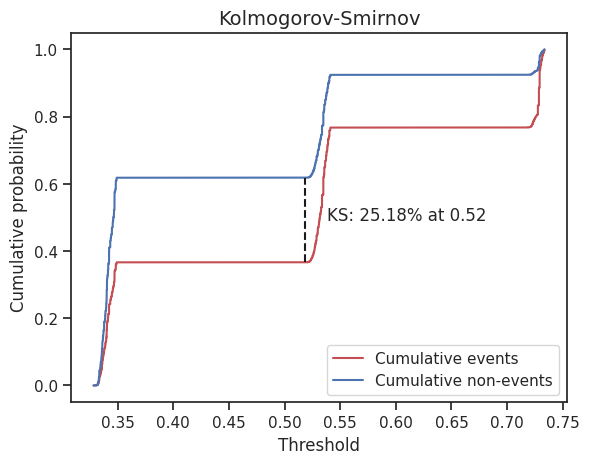

In [0]:
plot_ks(y_train, y_pred_train)

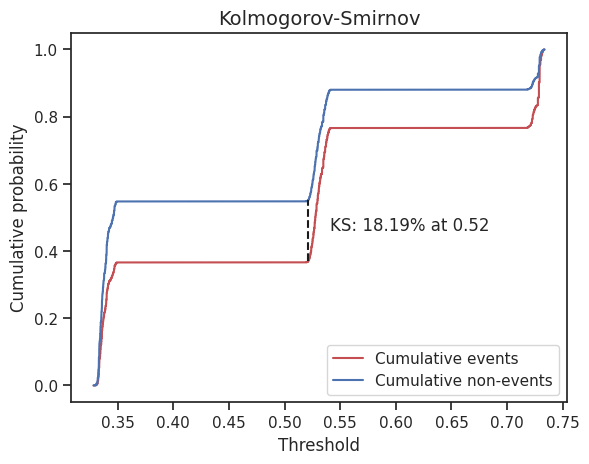

In [0]:
plot_ks(y_test, y_pred_test)

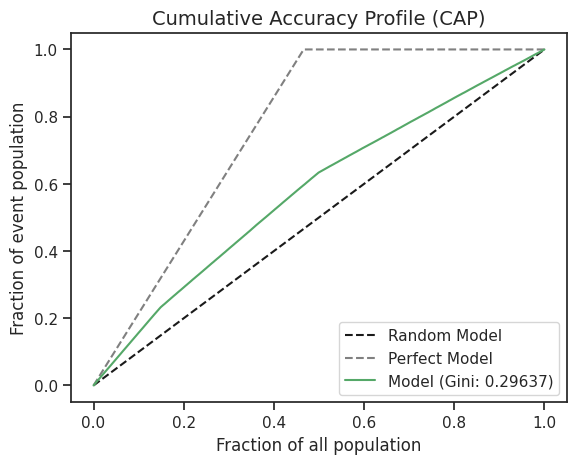

In [0]:
plot_cap(y_train, y_pred_train)

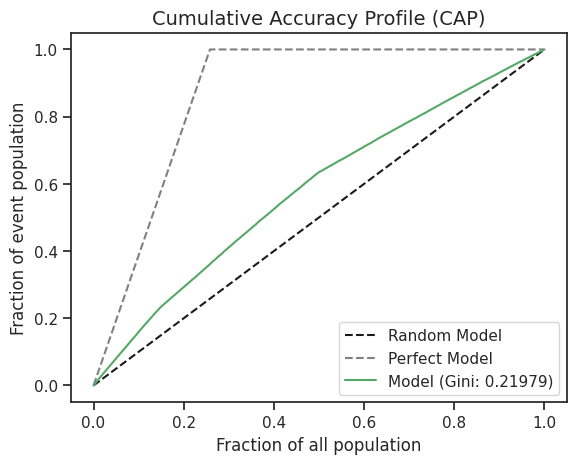

In [0]:
plot_cap(y_test, y_pred_test) 

In [0]:
probability_train = y_pred_train
df_train = adjusted_prediction(data_train.target, probability_train, 0.52, 0.52)
model_metrics(df_train)
#plot_model(df_train)

Accuracy: 0.6253771251614525
Balanced Accuracy: 0.6258905048376158
ks: 0.25128120585253994
ROC AUC: 0.6481836767449024
Gini: 0.2963673534898048
Negative Predicted value:  0.5915858545502972
Positive Predicted value:  0.6590336864038896
Sensitivity:  0.618335068108793
Specificity:  0.6334459415664384
tp, fn, fp, tn=:  [273267, 168673, 141381, 244322]
Confusion Matrix:
[[273267 168673]
 [141381 244322]]
              precision    recall  f1-score   support

           0       0.66      0.62      0.64    441940
           1       0.59      0.63      0.61    385703

    accuracy                           0.63    827643
   macro avg       0.63      0.63      0.62    827643
weighted avg       0.63      0.63      0.63    827643



In [0]:
probability_test = y_pred_test
df_test = adjusted_prediction(data_test.target, probability_test, 0.52, 0.52)
model_metrics(df_test)
#plot_model(df_test)

Accuracy: 0.5703587043910175
Balanced Accuracy: 0.5907248044281859
ks: 0.18155621574916847
ROC AUC: 0.6098944726800274
Gini: 0.21978894536005478
Negative Predicted value:  0.32792006837808363
Positive Predicted value:  0.8110856666252076
Sensitivity:  0.5486163347717645
Specificity:  0.6328332740846072
tp, fn, fp, tn=:  [110860, 91212, 25821, 44504]
Confusion Matrix:
[[110860  91212]
 [ 25821  44504]]
              precision    recall  f1-score   support

           0       0.81      0.55      0.65    202072
           1       0.33      0.63      0.43     70325

    accuracy                           0.57    272397
   macro avg       0.57      0.59      0.54    272397
weighted avg       0.69      0.57      0.60    272397

